# Lecture III: Recurrent Neural Network
This homework aims to help you understand Recurrent Neural Network by building a RNN classifier on Japanese Vowels from different male speakers. 

As usual, we will first import some useful modules:

In [ ]:
# pylint: disable=E1101,R,C
import numpy as np
import os
import argparse
import time
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import gzip
import pickle
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchsnooper
from torch.cuda.amp import autocast 
torch.set_default_tensor_type(torch.FloatTensor)

The Japanese Vowel dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels). For a detailed description, please look at this website. First, we will download the dataset:

In [3]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/ae.train
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/ae.test
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/size_ae.train
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/size_ae.test

File ‘ae.train’ already there; not retrieving.

File ‘ae.test’ already there; not retrieving.

File ‘size_ae.train’ already there; not retrieving.

File ‘size_ae.test’ already there; not retrieving.



This dataset contains 9 male japanese speaker pronouncing the utterance /ae/. The data is decoded by Linear Predictive Coding. A detail of LPC can be found [here](https://en.wikipedia.org/wiki/Linear_predictive_coding). Each utterance contains 12 LPC basis, thus for each time index, the time series will contain 12 channels.

## Part I: Dataset

First, we will need to prepare the dataset using `Dataset()` class. Since in last home work, I have gone through the detail of this class, I will skip most of the technical details.

In [4]:
class WaveForms(Dataset):

    def __init__(self,plot=True):
        
        self.max_length = 500 # The maximum possible length of each utterance contains 29 samples
        self.num_LPC = 1    # The LPC spectrum contains 12 coefficients, so the data shape will be [29,12]
        
        train_data, train_label = self.read_vowels("../Data/Train_1_0.2.npy","../Data") ## I don´t know yet what the size file does
        test_data, test_label = self.read_vowels("ae.test","size_ae.test")
        
        self.size = len(train_data) + len(test_data)
        self.train_test_split = len(train_data)
        
        self.data = train_data + test_data
        self.labels = train_label + test_label
        
        if plot:
            self.plot_data()
        
        
    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size


    def __getitem__(self, idx):
        '''
        This function extract a single entry from the dataset at the given index idx
        In this dataset, the data has variable length, so we need to pad 
        the LPC coefficients to have the same length for training purpose
        '''
        output = np.zeros((self.max_length, self.num_LPC))
        data = self.data[idx]
        output[:data.shape[0]] += data
        return output, self.labels[idx]
    
    def get_train_test_split(self):
        '''
        This function get the train test split size of the dataset
        '''
        return self.train_test_split
    
    def read_vowels(self, file, size_file):
        vowel_units = []
        speaker_size = []
        labels = []
        #Read out the LPC value of all vowels
        with open(file, "r") as f:
            current_vowel = []
            for line in f.readlines():
                if line == '\n':
                    vowel_units.append(np.array(current_vowel))
                    current_vowel = []
                    continue
                current_vowel.append(np.array(line.strip().split(" "),dtype=float).tolist())
        #Read out the size of samples by 9 speakers
        with open(size_file, "r") as f:
            speaker_size = np.array(f.readline().strip().split(" "),dtype=int)
            assert len(speaker_size) == 9 # If speaker size is not 9, then there's something wrong
        #Assign a label to each speaker, speaker 1 == 0 .....speaker 9 == 8:
        for speaker_label in range(9):
            labels += [speaker_label] * speaker_size[speaker_label]
        # Check if the number of label equals to number of data
        # If not, there is something wrong
        assert len(vowel_units) == len(labels)
        return vowel_units, labels
            
                    
        
    
    def plot_data(self):
        '''
        This function plots the LPC spectrum of 9 random utterances
        '''
        plt.figure(figsize=(20,12))
        sample_index = np.random.randint(low=0,high=self.__len__(), size = 9)
        for i in range(9):
            plt.subplot(3,3, i+1)
            voice, label = self.__getitem__(sample_index[i])
            utt_length = voice.shape[0]
            for i in range(voice.shape[-1]):
                plt.plot(np.arange(utt_length), voice[:,i])
            plt.xlabel("Time Index")
            plt.ylabel("LPC Coefficients")

Similarly, we can check the form of data by plotting the LPC spectrum coefficients. The trailing 0s comes from the padding we performed within the dataset:

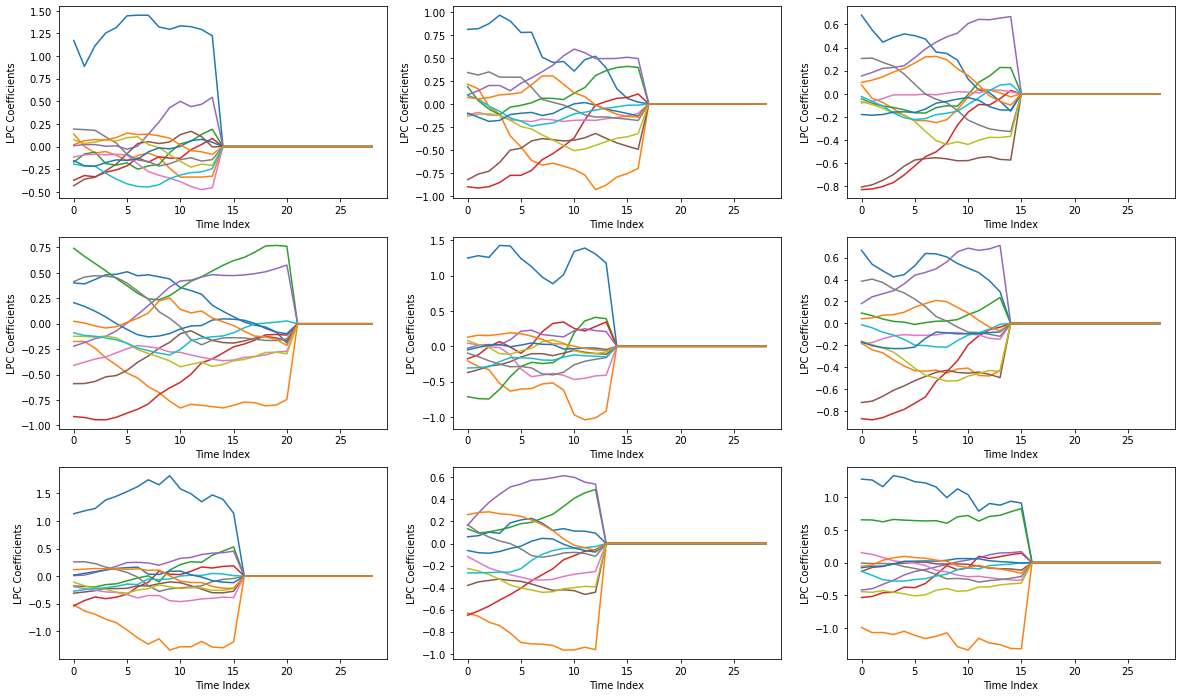

In [5]:
JapaneseVowelDataset()

## Part II: Recurrent Neural Network
In this part, we will buid an LSTM based recurrent neural network model to analyze the input LPC spectrum. Since this is the second time we build a NN, I will leave most of the work to you. Some useful resources include:
- [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm)
- [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)
- [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html?highlight=leakyrelu#torch.nn.LeakyReLU)
- [nn.Sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential)

Some useful tips for building the recurrent neural network:
- Read [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) carefully, make sure you understand the input and output shape of the LSTM layer. The [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) layer outputs `output, (h_n, c_n)`:
    -  `output` has a shape of `(Seq_len,Batch_size,num_direction*hidden_size)`, it contains all intermediate hidden state outputs of the last layer. Note that there is a `batch_first` flag in LSTM input which may change the output shape to `(Batch_size,Seq_len,num_direction*hidden_size)`. If you want to select only the last hidden state, you shoud simply index the `Seq_len` dimension.
    -  `(h_n, c_n)` contains the last hidden state outputs of each layers
- Remember that you want to select only the the **last hidden state output**. You can either extract it from `output` or `h_n`.
- Then you will feed the **last hidden state output** into `self.fc_classifier`. You will need to adjust the `hidden_size` of LSTM output and the input size of first fully connected layer in `self.fc_classifier` to match
- Make sure the output of RNN model has the shape of [BATCHSIZE,9], since we have 9 speakers in the dataset we'd like to classify into

In [16]:
'''
This script contains the PositionalUNet network along with 3 candidate discriminators:
* RNN+Attention discriminator
* CNN+PositionalEncoding Discriminator
* Fully Connected Discriminators
we have tested all 3 discriminators, turns out that the RNN+Attention works the best
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import math



class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=11, padding=5,bias=False),
            nn.BatchNorm1d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(mid_channels, out_channels, kernel_size=7, padding=3,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose1d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]

        x1 = F.pad(x1, [diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            torch.nn.Conv1d(in_channels, out_channels, kernel_size=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels, out_channels, kernel_size=1),
        )

    def forward(self, x):
        return self.conv(x)
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, start=0, dropout=0.1, max_len=10000,factor=1.0):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.factor = factor

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(1, 2)
        self.register_buffer('pe', pe)
        self.start = start
    # @torchsnooper.snoop()
    def forward(self, x):
        x = x + self.factor*self.pe[:,:,self.start:(self.start+x.size(2))]
        x = self.dropout(x)
        return x
    


In [50]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.bilinear = True
        
        multi = 40
        
        self.inc = DoubleConv(12, multi) #1 instead of 12 for feeding 1 wave form at a time --> input channels 
        self.down1 = Down(multi, multi*2)
        self.down2 = Down(multi*2, multi*4)
        self.down3 = Down(multi*4, multi*8)
        factor = 2 if self.bilinear else 1
        self.down4 = Down(multi*8, multi*16 // factor)
        
       
        
        self.up1 = Up(multi*16, multi*8 // factor, self.bilinear)
        self.up2 = Up(multi*8, multi*4 // factor, self.bilinear)
        self.up3 = Up(multi*4, multi*2 // factor, self.bilinear)
        self.up4 = Up(multi*2, multi // factor, self.bilinear)
        self.outc = OutConv(multi // factor, 2)
        #self.softmax = torch.nn.Softmax(dim=-1)
        self.sigmoid = torch.Sigmoid()
    
    #@torchsnooper.snoop()
    def forward(self, x):
        x = x.transpose(1,2)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        #Two inputs in the next ones because of the contraction paths 
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        
        output = output.transpose(1,2)
#         output = self.softmax(output)
        
        return output


Similar to what we did in Lecture 2 homework, we will pull out 1 event from the dataset, and use `torchsnooper.snoop()` to check the network structure. Before proceeding to the next part, you may want to stare at the tensor output of `torchsnooper.snoop()` carefully to understand how the data is flowing within the RNN network.

In [51]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(JapaneseVowelDataset(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
#print(test_event.size, test_event)
test_network = UNet()
print(test_network(test_event))

tensor([[[ 5.3540e-01, -7.0938e-01],
         [ 3.4256e-01, -1.0685e+00],
         [ 1.9297e-01, -3.3742e-01],
         [-1.9284e-02,  3.2093e-02],
         [ 1.7158e-01, -3.2492e-01],
         [-2.1134e-02, -2.7330e-01],
         [ 1.0662e-01,  9.2682e-04],
         [ 4.9106e-01, -1.0483e-01],
         [ 7.2981e-01,  4.9332e-02],
         [ 6.7757e-01,  1.3197e-01],
         [ 2.5909e-01,  3.2483e-02],
         [ 5.1078e-01,  3.2950e-01],
         [ 4.5575e-01,  1.5905e-03],
         [ 6.9526e-01, -2.4548e-01],
         [ 6.3702e-01,  3.7610e-01],
         [ 6.5910e-01,  4.6286e-01],
         [ 6.2924e-01, -1.5901e-02],
         [ 3.6532e-01, -3.0220e-01],
         [ 6.3139e-01, -7.2290e-02],
         [ 8.6122e-01,  3.1222e-01],
         [ 4.3318e-01, -1.8802e-02],
         [ 4.1574e-01, -1.6526e-01],
         [ 7.7109e-01, -4.4773e-01],
         [ 3.7294e-01, -4.2896e-01],
         [ 1.9049e-01, -2.3287e-01],
         [ 1.5295e-01, -2.6928e-01],
         [ 6.3673e-01,  1.0313e-01],
 

## Part III: Training
After building the neural network, we train it the same way as we did in Lecture 2:

In [52]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS =20
LEARNING_RATE =1e-3 # 1e-2 is a good learning rate for general purpose
BATCH_SIZE=5

In [53]:
def set_up_classifier():
    classifier = UNet() # Define CNN neural network classifier
    classifier.to(DEVICE)     # Send the classifier to DEVICE as we defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.to(DEVICE)

    #Define the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(),lr=LEARNING_RATE)
    
    return classifier, criterion, optimizer

In [54]:
def get_dataloader():
    dataset = JapaneseVowelDataset(plot=False)
    #Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] is the training dataset, indices [train_test_split, len(dataset)] is the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    #Shuffle the two indices list
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Define two subset random sampler to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisibe by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)
    
    return train_loader, test_loader

In [58]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()

loss_values = []
accuracy_values = []
y_true = []
y_pred = []

for epoch in range(NUM_EPOCHS):
    for i, (utterances, labels) in tqdm(enumerate(train_loader)):
        # utterances.shape = [5,29,12]
        # SS label size = [5,29,2]
        label_array = []
        for utt in utterances:
            first_dim = utt[:,0] != 0 # shape: (29,)
            second_dim = utt[:,0] == 0 # shape: (29,)
            label_vector = np.concatenate([first_dim[:,None], second_dim[:,None]],axis=-1)
            label_array.append(label_vector[None,:])
        labels = torch.Tensor(np.concatenate(label_array, axis=0))
        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.
        
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE)
        
        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())
    
    #After every epoch, evaluate the validation accuracy on the test loader
#     num_accurate = 0
#     num_images = 0
#     for utterances,labels in tqdm(test_loader):

#         classifier.eval() # This line set the neural network to evaluation mode, some layers perform differently in train and test mode.
        
#         #While validating the network, we do not want it to produce any gradient. This will also save us time/memory
#         with torch.no_grad():
            
#             # Convey images to device, then feed it to the neural network for network output
#             utterances = utterances.to(DEVICE).float()
#             outputs  = classifier(utterances)
            
#             # Get classification decision by reading out the maximum value on the 10-dimensional vector
#             decision = torch.argmax(outputs, dim=-1)
#             decision = decision.cpu().data.numpy().flatten() # copy decision to CPU and convert it to a numpy array
#             labels = labels.cpu().data.numpy().flatten()
            
#             # Update the list of truth value and network predictions in last epoch:
#             if epoch == (NUM_EPOCHS-1):
#                 y_true += list(labels)
#                 y_pred += list(decision)
            
#             #Calculate accuracy by # of correct prediction / total numbers

#             num_accurate += np.sum((decision - labels) == 0)
#             num_images += len(decision)
#     accuracy_values.append(num_accurate/num_images)  


# of params in model:  7013202


54it [00:09,  5.86it/s]


Epoch [1/20], Iter [54/54] Loss: 40.5188

54it [00:09,  5.88it/s]


Epoch [2/20], Iter [54/54] Loss: 39.6924

54it [00:09,  5.83it/s]


Epoch [3/20], Iter [54/54] Loss: 39.7790

54it [00:09,  5.86it/s]


Epoch [4/20], Iter [54/54] Loss: 39.3156

54it [00:09,  5.70it/s]


Epoch [5/20], Iter [54/54] Loss: 39.2070

54it [00:09,  5.84it/s]


Epoch [6/20], Iter [54/54] Loss: 39.2676

54it [00:09,  5.84it/s]


Epoch [7/20], Iter [54/54] Loss: 39.3038

54it [00:09,  5.85it/s]


Epoch [8/20], Iter [54/54] Loss: 39.0311

54it [00:09,  5.46it/s]


Epoch [9/20], Iter [54/54] Loss: 39.0626

54it [00:09,  5.87it/s]


Epoch [10/20], Iter [54/54] Loss: 38.9690

54it [00:09,  5.76it/s]


Epoch [11/20], Iter [54/54] Loss: 40.3135

54it [00:09,  5.74it/s]


Epoch [12/20], Iter [54/54] Loss: 39.0664

54it [00:09,  5.67it/s]


Epoch [13/20], Iter [54/54] Loss: 38.9925

54it [00:09,  5.83it/s]


Epoch [14/20], Iter [54/54] Loss: 39.5644

54it [00:09,  5.87it/s]


Epoch [15/20], Iter [54/54] Loss: 39.5983

54it [00:09,  5.87it/s]


Epoch [16/20], Iter [54/54] Loss: 38.9703

54it [00:09,  5.86it/s]


Epoch [17/20], Iter [54/54] Loss: 39.0231

54it [00:09,  5.89it/s]


Epoch [18/20], Iter [54/54] Loss: 38.9807

54it [00:09,  5.93it/s]


Epoch [19/20], Iter [54/54] Loss: 39.2226

54it [00:09,  5.90it/s]

Epoch [20/20], Iter [54/54] Loss: 39.7517

Does the training loss reduce to a value below 2.0? If not, there are a few things you can try:
- Playing with the learning rate and see how it affects the training.
- Adding more layers by changing the `num_layers` variable in LSTM class.
- In RNN, it's very easy to get gradient vanishing in the `self.classifier` part, try to use **only one fully connected layers**.
- Set `bidirectional=True` for the LSTM layer. **Caveats: Doing this will change the shape of LSTM output*

If you can get the loss to reduce to well below 2.0, proceed to the last part.

In [70]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(JapaneseVowelDataset(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
#print(test_event.size, test_event)
test_network = classifier
test_network.eval()
decision = torch.softmax(test_network(test_event),dim=-1)
print(decision)

tensor([[[9.9681e-01, 3.1882e-03],
         [9.9682e-01, 3.1805e-03],
         [9.9672e-01, 3.2834e-03],
         [9.9677e-01, 3.2350e-03],
         [9.9673e-01, 3.2707e-03],
         [9.9683e-01, 3.1662e-03],
         [9.9670e-01, 3.3040e-03],
         [9.9668e-01, 3.3207e-03],
         [9.9671e-01, 3.2891e-03],
         [9.9674e-01, 3.2650e-03],
         [9.9679e-01, 3.2127e-03],
         [9.9687e-01, 3.1251e-03],
         [9.9693e-01, 3.0726e-03],
         [9.9711e-01, 2.8860e-03],
         [9.9705e-01, 2.9462e-03],
         [9.9683e-01, 3.1687e-03],
         [9.9684e-01, 3.1566e-03],
         [9.9680e-01, 3.1961e-03],
         [9.9724e-01, 2.7618e-03],
         [9.9699e-01, 3.0100e-03],
         [1.5097e-04, 9.9985e-01],
         [1.6048e-04, 9.9984e-01],
         [1.5537e-04, 9.9984e-01],
         [1.4437e-04, 9.9986e-01],
         [1.4546e-04, 9.9985e-01],
         [1.4182e-04, 9.9986e-01],
         [1.3363e-04, 9.9987e-01],
         [1.4160e-04, 9.9986e-01],
         [1.5453e-04

## Part IV: Evaluate Training Results
After training, we will be able to evaluate our training results.

First, let's plot the learning curve, that is, the loss value with respect to the epochs:

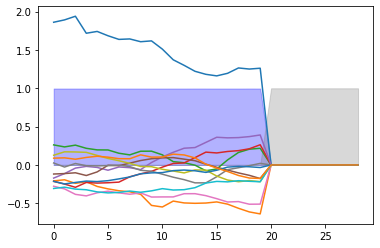

In [77]:
#test_event = test_event.detach().numpy()
#decision = decision.detach().numpy()
plt.plot(test_event[0,:,:])
#plt.plot(decision[0,:,:])
matplotlib.pyplot.fill_between(np.arange(29),0, decision[0,:,0], color = 'blue', alpha = 0.3)
matplotlib.pyplot.fill_between(np.arange(29),0, decision[0,:,1], color = 'grey', alpha = 0.3)
plt.show()